In [1]:
#============== NUMBA AND NUMPY ==============
import sys
import os
import numpy as np
from numpy import linalg as LA
import scipy.constants
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import matplotlib.gridspec as gridspec

import solvercqws2 as solver
from IPython.display import display, Math
from tabulate import tabulate

q = 1.602176e-19 #C
kb = 1.3806504e-23 #J/K
nii = 0.0
hbar = 1.054588757e-34
m_e= 9.1093826E-31 #kg
pi=np.pi
eps0= 8.8541878176e-12 #F/m
J2meV=1e3/q
from thomas_solve  import TDMA
import platform



In [2]:
from scipy.sparse import dia_matrix

class schro:
    def __init__(self,model,pote,particle='e'):
        self.dx       = model.dx
        self.dz       = model.dx
        self.n        = model.n_max
        self.subbands = model.subbands 
        self.xaxis    = model.xaxis
        self.z        = model.xaxis
        self.Fapp     = model.Fapp
        self.T           = model.T
        self.pote     = pote+self.Fapp*q*self.xaxis
        if particle=='e':
            self.me       = model.cb_meff
            self.Qc       = model.Qc
        elif particle=='hh':
            self.me       = model.vbhh_meff
            self.Qv       = model.Qv
        elif particle=='lh':
            self.me       = model.vblh_meff
            self.Qv       = model.Qv
        self.material  = model.material
    
        
    def QuantumSolutions(self):
            #self.xe    = np.zeros(self.subbands)
            #self.xpsi  = np.zeros((self.n,self.subbands))
            self.cb = self.pote
            #self.Hamiltonian_e  = H(self.cb,self.me,self.Fapp,self.dx,self.n)
            # Eigenvalues and Eigenvectors to electrons in Conduction bands
            #upper_e       = np.diag(self.Hamiltonian_e,k=1)
            #diagonal_e    = np.diag(self.Hamiltonian_e,k=0)
            #lower_e       = np.diag(self.Hamiltonian_e,k=-1)
            #Hn_e          = scipy.sparse.diags(H_diags_e, [-1,0,1], format='csc')
            #self.ew,self.psiw= eigs(Hn_e,k=self.subbands, which='LR', sigma=sigma)
            # We shift the potential so that it is possitive with the minimum value around zero
            q=1.60217646e-19
            h=6.626068e-34
            hbar=1.05457148e-34
            m0=9.10938188e-31
            fe =self.pote
            z = self.xaxis
            l = max(z)
            e0 = hbar ** 2 / (m0 * l ** 2)
            quasiconfined=0.0
            dz = np.gradient(z / l)
            N = len(fe)
            offset = np.amin(fe)
            fe = (fe - offset)/e0
            m = self.me/m0
            # Vectorise effective mass differences to avoid a loop
            m = np.insert(m, (0, len(m)), (m[0], m[-1]))
            m_a = m[0:-2]  # m_(j-1) from Frensley, W. R. (1991)
            m_b = m[1:-1]  # m_j
            m_c = m[2:]  # m_(j+1)
            # These are the interior diagonals of equation 18 in the above ref.
            axis = 0.25 / dz ** 2 * (
            1 / m_a + 2 / m_b + 1 / m_c) + fe   # d_j from Frensley, W. R. (1991), modified to include kt and normalised variables
            upper = 0.25 / dz ** 2 * (1 / m_a + 1 / m_b)  # s_(j+1)
            lower = 0.25 / dz ** 2 * (1 / m_b + 1 / m_c)  # s_j

            index = (-1, 0, 1)
            diagonals = (-lower, axis, -upper)
            H = dia_matrix((diagonals, index), shape=(N, N))
            sigma=0.0
            num=(self.subbands,self.subbands)
            E, Psi = eigs(H, k=num[0], which='LR', sigma=sigma)
            potmax = max(fe) + quasiconfined * q / e0
            if quasiconfined < 0.0:
                potmax = max(E)
            confined_levels = [i for i, e in enumerate(E) if (e < potmax and i < num[1])]
            E = E[confined_levels].real
            Psi = np.array(Psi[:, confined_levels])
            #Psi = [p / np.sqrt(np.trapz(p*p.conjugate(), x=z.T)) for p in Psi.real]
            E = E * e0 + offset
            
            for i in range(len(confined_levels)):
                Psi[:,i] = Psi[:,i]/np.sqrt(np.trapz(abs(Psi[:,i])**2))
            
            class Results(): pass
            results          = Results()
            results.z        = z
            results.psi      = Psi.real
            results.e        = np.array(E)
            results.cb       = self.pote
            results.dx       = dz
            results.subbands = confined_levels 
            return results

Total layer number: 4
510


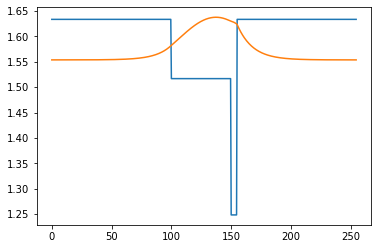

CPU times: user 145 ms, sys: 11.8 ms, total: 156 ms
Wall time: 155 ms


In [8]:
%%time
from solvercqws import H
import solvercqws as solver
from scipy.sparse import dia_matrix
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import eigsh

class Structure(object): pass
sem01 = Structure() # this will be our datastructure
# TEMPERATURE
sem01.T = 30.0#Kelvin
# Binding Energy
# Band Offset ratios
sem01.Qc = 0.65
sem01.Qv = 0.35
# Total subband number to be calculated for electrons
sem01.subbands = 10
# APPLIED ELECTRIC FIELD
sem01.Fapp = 0e5 # (V/m)
# For 1D, z-axis is choosen
sem01.gridfactor =0.05#nm
sem01.structure_name="sqw-v1"
sem01.HHBinding =6.1e-3 #meV
sem01.LHBinding =6.8e-3 #meV
# Band Offset ratios
# REGIONS
# Region input is a two-dimensional list input.
#         | Thickness (nm) | Material | Alloy fraction | Doping(cm^-3) | n or p type |

width=5.0
sem01.material =[
         [10.0, 'AlGaAs',   0.15,  0e18, 'i','b'],
         [width,'GaAs'  ,     0,   0e18, 'i','w'],
         [0.5, 'InAs',   0.0,  0e18, 'i','b'],
          [10.0, 'AlGaAs',   0.15,  0e18, 'i','b'],

]
# sem01.material =[
#          [20.0, 'AlGaAs',   0.4,  1.3e18, 'i','b'],
#          [3.0,'GaAs'  ,     0,   1.3e18, 'n','w'],
#          [25.0, 'AlGaAs',   0.4,  1.3e18, 'i','b'],
#          [7,'GaAs'  ,     0,   0e18, 'i','w'],
#          [15, 'AlGaAs',   0.2,  0e18, 'i','b'],
#          [5,'GaAs'  ,     0,   0e18, 'i','w'],
#          [25.0, 'AlGaAs',   0.4,  1.3e18, 'i','b'],
#          [3.0,'GaAs'  ,     0,   1.3e18, 'n','w'],\
#          [20.0, 'AlGaAs',   0.4,  1.3e18, 'i','b'],
# ]
sem01.material
str01 = sem01
nm = 1e-9
# RUN SIMULATION
model01 = solver.StructureFrom(str01) #
#model01.cb = model01.cb-np.min(model01.cb)

# RUN SIMULATION
#model02.cb = model02.cb-np.min(model02.cb)

sol=schro(model01,model01.cb).QuantumSolutions()

print(len(model01.xaxis))
plt.plot(model01.xaxis/1e-10,model01.cb/q)
plt.plot(model01.xaxis/1e-10,10*abs(sol.psi[:,0])**2+sol.e[0]/q)

plt.show()

# Export data

In [16]:
cb = np.array([model01.xaxis/1e-9,model01.cb/q,10*abs(sol.psi[:,0])**2+sol.e[0]/q]).T
# psi = np.array([model01.xaxis/1e-9,10*abs(sol.psi[:,0])**2+sol.e[0]/q]).T

np.savetxt("data/sqwc-p1.dat",cb,delimiter=',')

In [17]:
cb

array([[ 0.        ,  1.63359365,  1.5537991 ],
       [ 0.05      ,  1.63359365,  1.55379916],
       [ 0.1       ,  1.63359365,  1.55379924],
       ...,
       [25.35      ,  1.63359365,  1.55379948],
       [25.4       ,  1.63359365,  1.55379926],
       [25.45      ,  1.63359365,  1.55379913]])